In [26]:

import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from numpy.linalg import LinAlgError
#import pandas_datareader.data as web
import statsmodels.tsa.api as tsa
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_style('whitegrid')
import warnings
#stop warning
warnings.filterwarnings('ignore', category=FutureWarning)


# After downloading data convert into log value

In [27]:
# stock_df = yf.download(tickers='BTC-USD', start='2018-01-01', end='2023-02-19')

# nvda_log = np.log(stock_df['Adj Close']).diff().dropna()

# nvda_log


# Load the local Stock data
stock_df = pd.read_csv('C:/Users/Developer/pythonProject/breakout_test/stock_data_olympic.csv',parse_dates=['Date'],index_col = 0)
nvda_log = np.log(stock_df['Close']).diff().dropna()
nvda_log





Date
2014-12-02    0.015812
2014-12-03   -0.006295
2014-12-04    0.005847
2014-12-07   -0.009009
2014-12-08    0.000000
                ...   
2023-02-01   -0.002903
2023-02-02    0.044768
2023-02-05    0.019953
2023-02-06   -0.004780
2023-02-07    0.052661
Name: Close, Length: 1935, dtype: float64

In [28]:
def plot_correlogram(x, lags=None, title=None):
    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    
    x.plot(ax=axes[0][0], title='Residuals')
    
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    
    probplot(x, plot=axes[0][1])
    
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    
    axes[1][0].set_xlabel('Lag')
    
    axes[1][1].set_xlabel('Lag')
    
    fig.suptitle(title, fontsize=14)
    
    sns.despine()
    
    fig.tight_layout()
    
    fig.subplots_adjust(top=.9)
    
    return

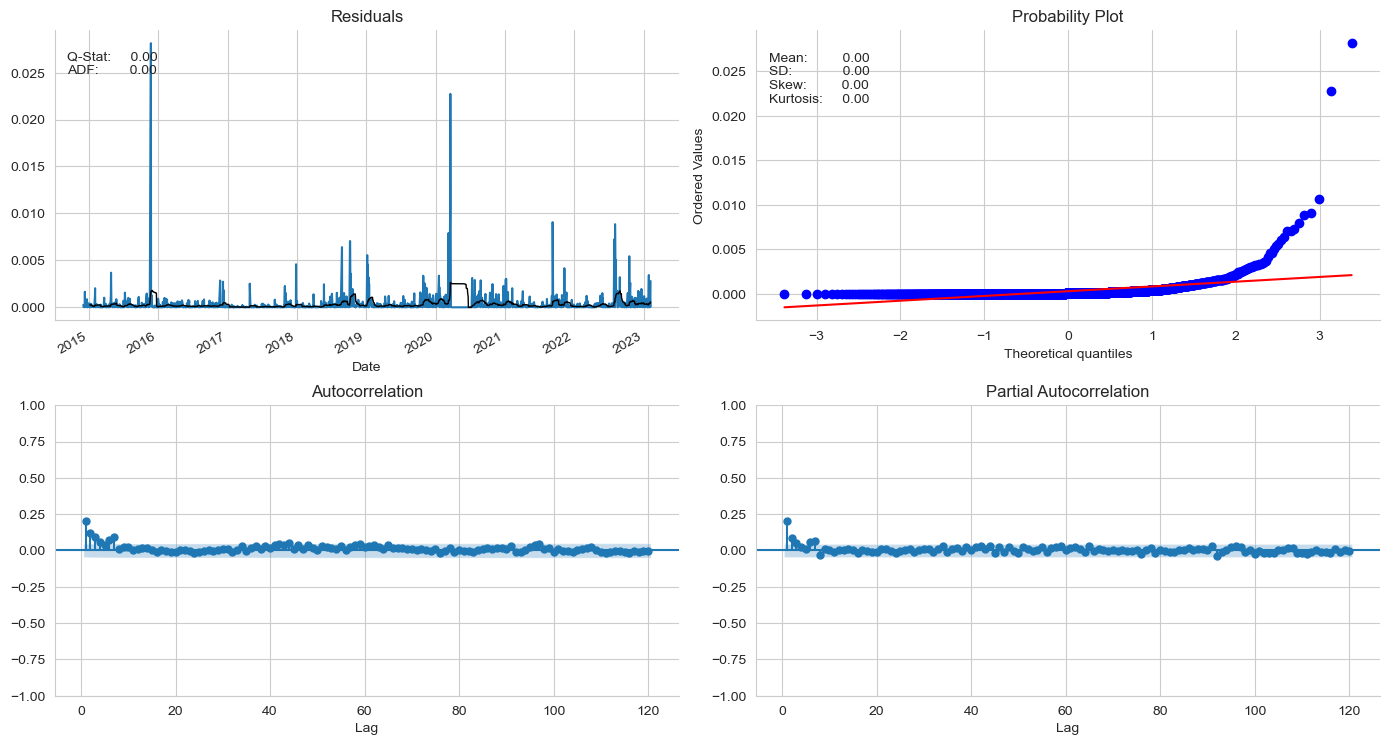

In [29]:
nvda_daily_vol = (nvda_log-nvda_log.mean())**2

plot_correlogram(x=nvda_daily_vol,
                 lags=120,
                 title=None)

In [30]:
from arch import arch_model

##### Change the number of years defends on how many years data has been used ####################
#number of year data * Working days of a year #############

trainsize = 5*254

data = nvda_log.clip(lower=nvda_log.quantile(.05),
                     upper=nvda_log.quantile(.95))

T = len(nvda_log)

results = {}

for p in range(1, 5):
    
    for q in range(1, 5):
        
        print(f'{p} | {q}')

        result = []

        for s, t in enumerate(range(trainsize, T-1)):

            train_set = data.iloc[s:t]

            test_set = data.iloc[t+1]

            model = arch_model(y=train_set, p=p, q=q).fit(disp='off')

            forecast = model.forecast(horizon=1)

            mu = forecast.mean.iloc[-1, 0]

            var = forecast.variance.iloc[-1, 0]

            result.append([(test_set-mu)**2, var])

        df = pd.DataFrame(result, columns=['y_true', 'y_pred'])

        results[(p, q)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))

1 | 1
1 | 2
1 | 3
1 | 4
2 | 1
2 | 2
2 | 3
2 | 4
3 | 1
3 | 2
3 | 3
3 | 4
4 | 1
4 | 2
4 | 3
4 | 4


In [31]:
results

{(1, 1): 0.0002525843011271165,
 (1, 2): 0.00025096333456521965,
 (1, 3): 0.0002513509591882308,
 (1, 4): 0.00025158874711753073,
 (2, 1): 0.000251855619149881,
 (2, 2): 0.0002505457004610668,
 (2, 3): 0.000250313462512918,
 (2, 4): 0.0002505899577382046,
 (3, 1): 0.0002510680996971335,
 (3, 2): 0.00024990799666014255,
 (3, 3): 0.0002502833523700494,
 (3, 4): 0.00024980542110092515,
 (4, 1): 0.0002512627130445216,
 (4, 2): 0.0002501058363207345,
 (4, 3): 0.0002506545273043687,
 (4, 4): 0.00025152353254916104}

In [32]:
pd.DataFrame(results, index=pd.Series(0)).unstack().idxmin()

(3, 4, 0)

In [33]:
data = nvda_log.clip(lower=nvda_log.quantile(.05),
                     upper=nvda_log.quantile(.95))

best_model = arch_model(y=data, p=1, q=3).fit(update_freq=5, disp='off')

print(best_model.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                5727.48
Distribution:                  Normal   AIC:                          -11443.0
Method:            Maximum Likelihood   BIC:                          -11409.6
                                        No. Observations:                 1935
Date:                Tue, Feb 21 2023   Df Residuals:                     1934
Time:                        22:43:05   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -3.0226e-04  2.581e-04     -1.171      0.

In [34]:
data = nvda_log.to_frame('nvda_log_ret')

################ Here We take last 70 working days ###########################################

data['variance'] = data['nvda_log_ret'].rolling(70).var()

################ Here, Year have to change ###########################################

data = data['2022':]

def predict_volatility(x):  
    
    ######################### Confiqure the Model with above result  ##############################################
    
    best_model = arch_model(y=x, p=1, q=3).fit(update_freq=5, disp='off')
    
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1, 0]
    
    print(x.index[-1])
    
    return variance_forecast

data['predictions'] = data['nvda_log_ret'].rolling(70).apply(lambda x: predict_volatility(x))

data = data.dropna()

data

2022-04-12 00:00:00
2022-04-13 00:00:00
2022-04-17 00:00:00
2022-04-18 00:00:00
2022-04-19 00:00:00
2022-04-20 00:00:00
2022-04-21 00:00:00
2022-04-24 00:00:00
2022-04-25 00:00:00
2022-04-26 00:00:00
2022-04-27 00:00:00
2022-04-28 00:00:00
2022-05-05 00:00:00
2022-05-08 00:00:00
2022-05-09 00:00:00
2022-05-10 00:00:00
2022-05-11 00:00:00
2022-05-12 00:00:00
2022-05-16 00:00:00
2022-05-17 00:00:00
2022-05-18 00:00:00
2022-05-19 00:00:00
2022-05-22 00:00:00
2022-05-23 00:00:00
2022-05-24 00:00:00
2022-05-25 00:00:00
2022-05-26 00:00:00
2022-05-29 00:00:00
2022-05-30 00:00:00
2022-05-31 00:00:00
2022-06-01 00:00:00
2022-06-02 00:00:00


C:\Users\Developer\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2022-06-05 00:00:00
2022-06-06 00:00:00
2022-06-07 00:00:00
2022-06-08 00:00:00
2022-06-09 00:00:00
2022-06-12 00:00:00
2022-06-13 00:00:00
2022-06-14 00:00:00
2022-06-15 00:00:00
2022-06-16 00:00:00
2022-06-19 00:00:00
2022-06-20 00:00:00
2022-06-21 00:00:00
2022-06-22 00:00:00
2022-06-23 00:00:00
2022-06-26 00:00:00
2022-06-27 00:00:00
2022-06-28 00:00:00
2022-06-29 00:00:00
2022-06-30 00:00:00
2022-07-03 00:00:00
2022-07-04 00:00:00
2022-07-05 00:00:00
2022-07-06 00:00:00
2022-07-07 00:00:00
2022-07-12 00:00:00
2022-07-13 00:00:00
2022-07-14 00:00:00
2022-07-17 00:00:00
2022-07-18 00:00:00
2022-07-19 00:00:00
2022-07-20 00:00:00
2022-07-21 00:00:00
2022-07-24 00:00:00
2022-07-25 00:00:00
2022-07-26 00:00:00
2022-07-27 00:00:00
2022-07-28 00:00:00
2022-07-31 00:00:00
2022-08-01 00:00:00
2022-08-02 00:00:00
2022-08-03 00:00:00
2022-08-04 00:00:00
2022-08-07 00:00:00
2022-08-08 00:00:00
2022-08-10 00:00:00
2022-08-11 00:00:00
2022-08-14 00:00:00
2022-08-16 00:00:00
2022-08-17 00:00:00


C:\Users\Developer\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2022-09-26 00:00:00
2022-09-27 00:00:00
2022-09-28 00:00:00
2022-09-29 00:00:00
2022-10-02 00:00:00
2022-10-03 00:00:00
2022-10-04 00:00:00
2022-10-06 00:00:00
2022-10-10 00:00:00
2022-10-11 00:00:00
2022-10-12 00:00:00
2022-10-13 00:00:00
2022-10-16 00:00:00
2022-10-17 00:00:00
2022-10-18 00:00:00
2022-10-19 00:00:00
2022-10-20 00:00:00
2022-10-23 00:00:00
2022-10-24 00:00:00
2022-10-25 00:00:00
2022-10-26 00:00:00
2022-10-27 00:00:00
2022-10-30 00:00:00
2022-10-31 00:00:00
2022-11-01 00:00:00
2022-11-02 00:00:00
2022-11-03 00:00:00
2022-11-06 00:00:00
2022-11-07 00:00:00
2022-11-08 00:00:00
2022-11-09 00:00:00
2022-11-10 00:00:00
2022-11-13 00:00:00
2022-11-14 00:00:00
2022-11-15 00:00:00
2022-11-16 00:00:00
2022-11-17 00:00:00
2022-11-20 00:00:00
2022-11-21 00:00:00
2022-11-22 00:00:00
2022-11-23 00:00:00
2022-11-27 00:00:00
2022-11-28 00:00:00
2022-11-29 00:00:00
2022-11-30 00:00:00
2022-12-01 00:00:00
2022-12-04 00:00:00
2022-12-05 00:00:00
2022-12-06 00:00:00
2022-12-07 00:00:00


,nvda_log_ret,variance,predictions
Date,,,
2022-04-12,-0.002230,0.000106,0.000065
2022-04-13,0.000744,0.000106,0.000065
2022-04-17,-0.003724,0.000106,0.000064
2022-04-18,-0.018073,0.000109,0.000126
2022-04-19,-0.000760,0.000109,0.000072
...,...,...,...
2023-02-01,-0.002903,0.000365,0.000407
2023-02-02,0.044768,0.000388,0.000451
2023-02-05,0.019953,0.000392,0.000388


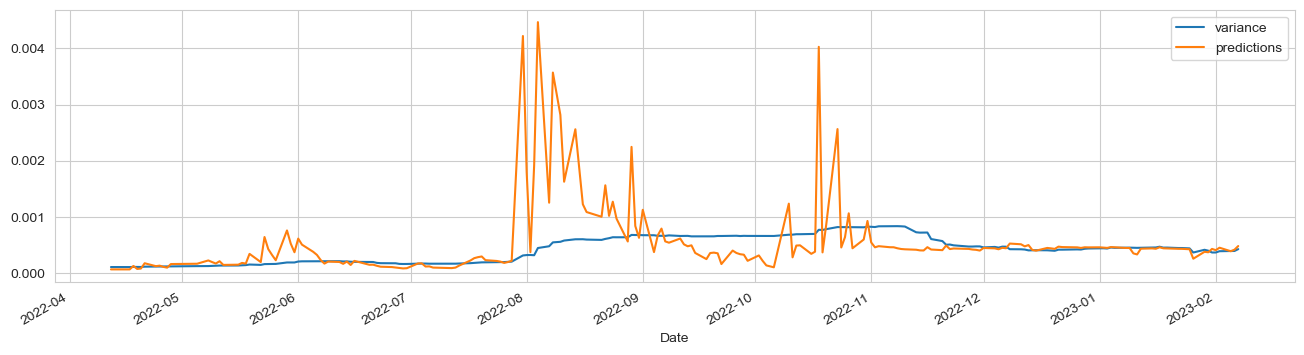

In [35]:
data[['variance', 'predictions']].plot(figsize=(16,4))

plt.show()

In [36]:
from pykalman import KalmanFilter

def KalmanFilterAverage(x):
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

data['fixed_predictions'] = KalmanFilterAverage(data['predictions'])

data

,nvda_log_ret,variance,predictions,fixed_predictions
Date,,,,
2022-04-12,-0.002230,0.000106,0.000065,0.000032
2022-04-13,0.000744,0.000106,0.000065,0.000043
2022-04-17,-0.003724,0.000106,0.000064,0.000049
2022-04-18,-0.018073,0.000109,0.000126,0.000065
2022-04-19,-0.000760,0.000109,0.000072,0.000066
...,...,...,...,...
2023-02-01,-0.002903,0.000365,0.000407,0.000410
2023-02-02,0.044768,0.000388,0.000451,0.000414
2023-02-05,0.019953,0.000392,0.000388,0.000412


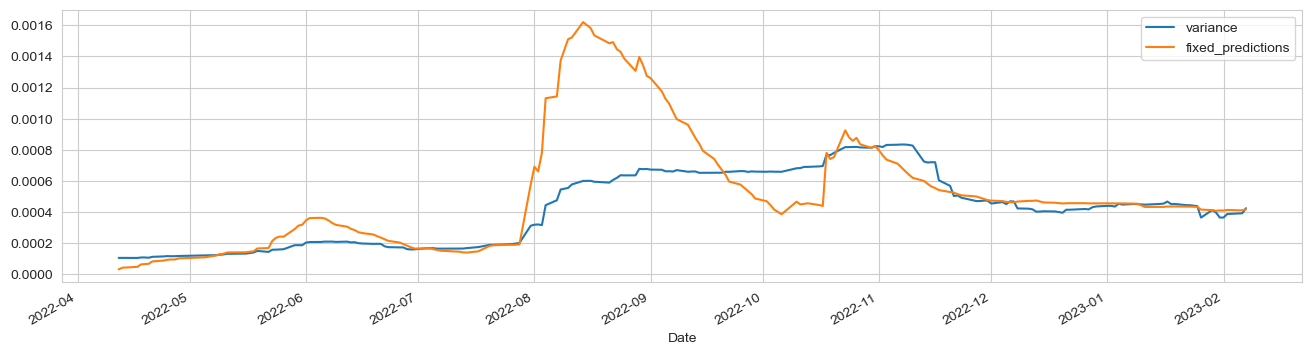

In [37]:
data[['variance', 'fixed_predictions']].plot(figsize=(16,4))

plt.show()

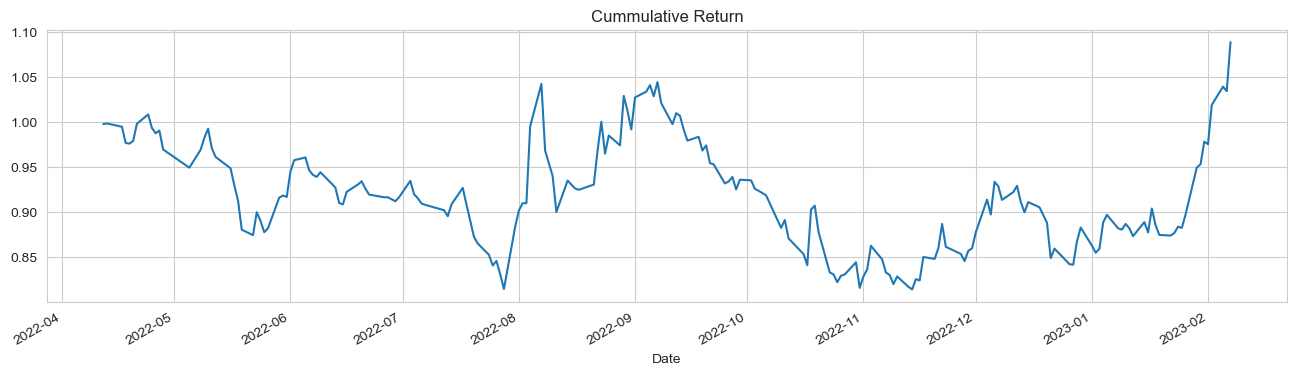

In [38]:
np.exp(np.log1p(data['nvda_log_ret']).cumsum()).plot(figsize=(16,4))

plt.title('Cummulative Return')

plt.show()

In [39]:
print(f"Sharpe Ratio : {(data['nvda_log_ret'].mean()/data['nvda_log_ret'].std())*(200**.5)}")

Sharpe Ratio : 0.4241977719874064


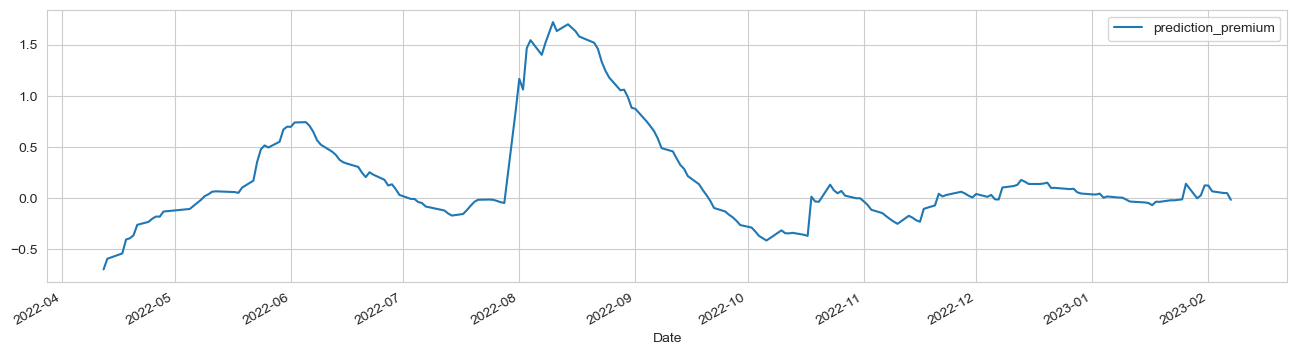

In [40]:
data['prediction_premium'] = (data['fixed_predictions']-data['variance'])/data['variance']

data[['prediction_premium']].plot(figsize=(16,4))

plt.show()

In [41]:
data['premium_diff'] = data['prediction_premium'].diff()

std = data['prediction_premium'].diff().std()

data['signal'] = data.apply(lambda x: 1 if (x['prediction_premium']<0)&(x['premium_diff']>std)
                            else (-1 if (x['prediction_premium']>0)&(x['premium_diff']<-std) else np.nan), axis=1)

data['signal'] = data['signal'].ffill(limit=5)

data['strategy_return'] = (data['nvda_log_ret']*data['signal'])

data

,nvda_log_ret,variance,predictions,fixed_predictions,prediction_premium,premium_diff,signal,strategy_return
Date,,,,,,,,
2022-04-12,-0.002230,0.000106,0.000065,0.000032,-0.695533,NaN,NaN,NaN
2022-04-13,0.000744,0.000106,0.000065,0.000043,-0.591612,0.103921,1.0,0.000744
2022-04-17,-0.003724,0.000106,0.000064,0.000049,-0.539518,0.052094,1.0,-0.003724
2022-04-18,-0.018073,0.000109,0.000126,0.000065,-0.403925,0.135593,1.0,-0.018073
2022-04-19,-0.000760,0.000109,0.000072,0.000066,-0.391625,0.012299,1.0,-0.000760
...,...,...,...,...,...,...,...,...
2023-02-01,-0.002903,0.000365,0.000407,0.000410,0.123289,-0.001072,NaN,NaN
2023-02-02,0.044768,0.000388,0.000451,0.000414,0.066971,-0.056319,NaN,NaN
2023-02-05,0.019953,0.000392,0.000388,0.000412,0.050848,-0.016123,NaN,NaN


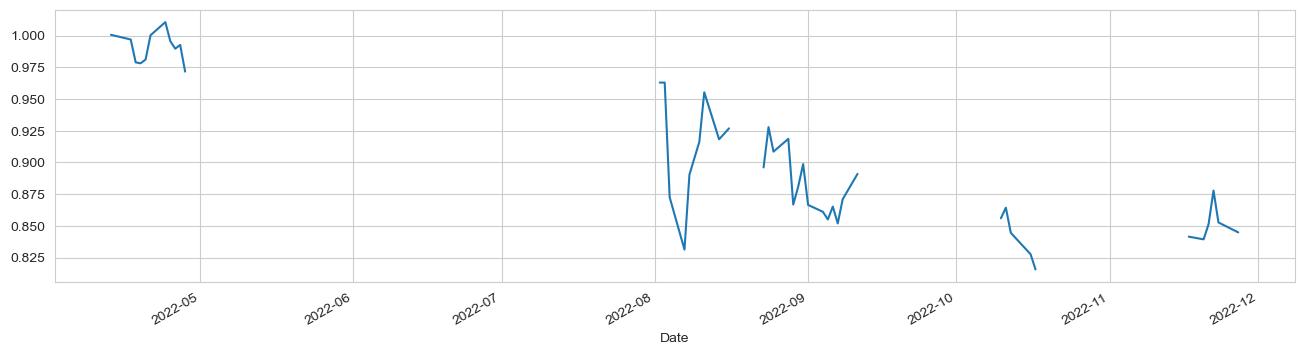

In [42]:
np.exp(np.log1p(data['strategy_return']).cumsum()).plot(figsize=(16,4))

plt.show()

In [43]:
print(f"Strategy Sharpe Ratio : {(data['strategy_return'].mean()/data['strategy_return'].std()) * (200**.5)}")

Strategy Sharpe Ratio : -1.6086314725352426
